In [ ]:
# EXECUTAR NO TERMINAL:

# !pip install pandas
# !pip install tensorflow
# !pip install numpy
# !pip install scikit-learn
# !pip install matplotlib

## BIBLIOTECAS

In [1]:
# Bibliotecas para data-science
import pandas as pd   #Biblioteca para Dataframes
#import dask.dataframe as dd  #Alternativa para pandas
import os   #Biblioteca para acesso dos arquivos
import glob   #Biblioteca para acesso dos arquivos
import numpy as np  #Biblioteca numérica

# Bibliotecas para problemas de otimização
#import pyomo.environ as pyo  #Biblioteca para otimização
from amplpy import AMPL

# Bibliotecas para redes neurais
import tensorflow as tf
import h5py
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from keras import backend as K  #Função para resetar a rede criada

# Bibliotecas gráficas
import matplotlib.pyplot as plt  #Biblioteca para plotar gráfico
from mpl_toolkits.mplot3d import Axes3D #Função para gerar gráfico 3D
from matplotlib.lines import Line2D #Função para gerar a legenda do gráfico com dois eixos Y

# Bibliotecas para medição de tempo
import time

# Possíveis bibliotecas úteis:
# import sympy as sp   #Biblioteca simbólica
# import scipy as scp  #Biblioteca matemática geral

# PANDAS

## Código Principal

### Definição das Variáveis

In [2]:
# DETERMINAÇÃO DAS TABELAS DA ONS

dir = "G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\ONS"

ons = {}
ons_usinas = {}

#Acessar o drive e armazenar os dados
for i in sorted(list(set(os.listdir(dir)) - {'desktop.ini'})):
  if len(list(set(os.listdir(f'{dir}\\{i}')) - {'desktop.ini'})) == 1:
    ons[i] = pd.read_csv(glob.glob(f'{dir}\\{i}\\*')[0], delimiter = ";")
  else:
    ons[i] = None

# Concatenar e armazenar os dados disponibilizados de forma mensal
for i in ons.keys():
  tab_temp=[]
  if ons[i] is None:
    for j in range(1,13):
      if os.path.isfile(f'{dir}\\{i}\\GERACAO_USINA-2_{i}_{j}.csv') == True:
        tab_temp.append(pd.read_csv(f'{dir}\\{i}\\GERACAO_USINA-2_{i}_{j}.csv', delimiter = ";"))
        ons[str(i)] = pd.concat(tab_temp)
      else:
        pass
  else:
    pass

  del tab_temp

  #Separação em usinas térmicas
  ons[i] = ons[i].loc[ons[i]['nom_tipousina']=='TÉRMICA']
  ons_usinas[i] = list(set(ons[i]['nom_usina'].values.tolist()))

  #Remover colunas desnecessárias
  ons[i] = ons[i].drop(columns=['id_subsistema',
                          'nom_subsistema',
                          'nom_estado',
                          'cod_modalidadeoperacao',
                          'nom_tipousina',
                          'ceg'])

  #Trocar o nome das colunas restantes
  ons[i] = ons[i].rename(columns={'din_instante':'Dia-Hora',
                            'id_estado':'Estado',
                            'nom_tipocombustivel':'Combustível',
                            'nom_usina':'Usina',
                            'val_geracao':'Geração'})

############################################################################################################

# DETERMINAÇÃO DAS TABELAS DA IEMA
dir = 'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\IEMA'

iema = {}
iema_emi_usinas = {}
iema_ger_usinas = {}
sheets = [0,1]

for i in sorted(list(set(os.listdir(dir)) - {'desktop.ini'})):
  iema[i] = pd.read_excel(f'{dir}\\{i}\\IEMA {i}.xlsx', sheet_name=sheets)

for i in iema.keys():
  iema_ger_usinas[i] = list(iema[i][0]['Usina'])
  iema_emi_usinas[i] = list(iema[i][1]['Usina'])

# ARMAZENAR OS DADOS DE GERAÇÃO
def armazenar(i,j,dir,arq):
  if os.path.exists(dir):
    if os.path.isfile(f'{dir}/{arq}') == False:
      ons[i].loc[ons[i]['Usina']==ons_usinas[i][j]].to_csv(f'{dir}/{arq}',index=False)
  else:
    os.makedirs(f'{dir}')
    ons[i].loc[ons[i]['Usina']==ons_usinas[i][j]].to_csv(f'{dir}/{arq}',index=False)

for i in ons:
  if i in iema_emi_usinas.keys(): # Apenas gera os dados de geração dos anos equivalente ao último relatório IEMA
    for j in range(len(ons_usinas[i])):
      if ons_usinas[i][j] in iema_emi_usinas[i]:
        dir = f'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas Geral\\{ons_usinas[i][j]}\\Dados de Geração'
        arq = f'{ons_usinas[i][j]}_{i}.csv'
        armazenar(i,j,dir,arq)


dir = f'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)'
usinas = list(set(os.listdir(f'{dir}')) - {'desktop.ini'})

############################################################################################################

#COMBINAÇÕES POSSÍVEIS DAS TERMELÉTRICAS

#Gás Natural e Ciclo Combinado
#Gás Natural e Ciclo Brayton
#Gás Natural e Motor Combustão

#Carvão Mineral e Ciclo Rankine

#Óleo Combustível e Motor Combustão

#Óleo Diesel e Motor Combustão
#Óleo Diesel e Ciclo Combinado

#############################################################################################################

### Modelo de Otimização  - PYOMO (Arrumar)

In [ ]:
#Objetivos:
  #Armazenar os dados de alfa, beta, gamma, omega, mi
  #Realizar um for para cada usina

def funcao_emissao(alfa, beta, gamma, omega, mi):  #Trabalhar com geração != 0
  PG = list(ons_otim_ger[i]['Geração'].loc[ons_otim_ger[i]['Usina'] == ons_otim_emi_usinas[i][j]])
  somatorio = 0
  for y in range(len(PG)):
    E = ((alfa * PG[y]**2 + beta * PG[y] + gamma) + omega * pyo.exp(mi * PG[y]))   #Valor 10^(-2) retirado
    somatorio += E
  return somatorio

def obj(model):
  ger_iema = float(iema[i][1]['Gases Emitidos (MIL TONELADAS DE CO2e)'].loc[iema[i][1]['Usina'] == ons_otim_emi_usinas[i][j]])
  return (funcao_emissao(model.alfa, model.beta, model.gamma, model.omega, model.mi) - ger_iema)**2

def pyomo(i,j):  #Código para realização do solver
  print(f'Realizando otimização da usina {ons_otim_emi_usinas[i][j]}')
  PG = list(ons_otim_ger[i]['Geração'].loc[ons_otim_ger[i]['Usina'] == ons_otim_emi_usinas[i][j]])

  model = pyo.ConcreteModel()

  model.alfa = pyo.Var(domain=pyo.NonNegativeReals)
  model.beta = pyo.Var(domain=pyo.NonNegativeReals)
  model.gamma = pyo.Var(domain=pyo.NonNegativeReals)
  model.omega = pyo.Var(domain=pyo.NonNegativeReals)
  model.mi = pyo.Var(domain=pyo.NonNegativeReals)

  model.cons = pyo.ConstraintList()

  for k in range(len(PG)):
    model.cons.add(expr = ((model.alfa * PG[k]**2 + model.beta * PG[k] + model.gamma) + model.omega * pyo.exp(model.mi * PG[k])) >= 0)

  model.cons.add(expr = model.alfa >= 0)
  model.cons.add(expr = model.beta >= 0)
  model.cons.add(expr = model.gamma >= 0)
  model.cons.add(expr = model.omega >= 0)
  model.cons.add(expr = model.mi >= 0)

  print('Todas as variáveis declaradas')

  model.obj_expr = pyo.Expression(rule=obj)
  model.obj = pyo.Objective(expr = model.obj_expr, sense=pyo.minimize)

  solver = pyo.SolverFactory('ipopt')
  solver.options['max_iter']= 1000
  solver.solve(model)
  print('Modelo otimizado')

  print(alfa())
  print(beta())
  print(gamma())
  print(omega())
  print(mi())

  #Salvando os resultados
  # tab = pd.DataFrame({'Coeficientes':['Alfa','Beta','Gamma','Omega','Mi'],'Valores':[model.alfa(),model.beta(),model.gamma(),model.omega(),model.mi()]})
  # tab.to_csv(f'{dir}\\{ons_otim_emi_usinas[i][j]}_Pyomo.csv',index=False)
  # print('Dados armazenados')

  #Limpando o modelo para disponibilizar armazenamento na memória
  del model

i='2020'
j=2
pyomo(i,j)
# for i in iema.keys():  #Código para resolver o solver de cada usina e armazenar no drive
#   print(f'Realizando otimização das usinas de {i}.')
#   for j in range(len(ons_otim_emi_usinas[i])):
#     dir = f'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)\\Completos\\{i}\\{ons_otim_emi_usinas[i][j]}\\Coeficientes'
#     if os.path.exists(dir):
#       if os.path.isfile(f'{dir}\\{ons_otim_emi_usinas[i][j]}_Pyomo.csv') == False:
#         pyomo(i,j)
#     else:
#       os.makedirs(f'{dir}')
#       pyomo(i,j)
#   print(f'Usinas de {i} concluídas.')
# print(f'Otimizações concluídas')

### Problema de Otimização - AMPL

In [ ]:
def ampl_model(iema_ampl,ons_ampl):
  # Criando uma instância AMPL
  ampl_instance = AMPL()

  # Definindo parâmetros
  PG = list(ons_ampl['Geração']) #(dividir por 100 para PU)
  E = iema_ampl['Gases Emitidos (MIL TONELADAS DE CO2e)'].loc[iema_ampl['Usina'] == ons_ampl['Usina'].iloc[0]].values[0] * 1000

  # Definindo o modelo em AMPL
  ampl_instance.eval(r'''
    set intervalos;

    param PG{intervalos};
    param E; # Emissão anual

    var alfa >= 0;
    var beta >= 0;
    var gamma >= 0;
    var omega >= 0;
    var mi >= 0;

    minimize MSE: 1/card(intervalos) * (sum{k in intervalos} (alfa*PG[k]^2 + beta*PG[k] + gamma + omega*exp(mi*PG[k])) - E)^2; #MSE -> mean squared error (dividir por 100 para PU)
  ''')

  ampl_instance.set['intervalos'] = range(0,len(PG))
  ampl_instance.param['PG'] = PG
  ampl_instance.param['E'] = E

  # Carregando o modelo
  ampl_instance.setOption('solver','C:\\Users\\Giovanni\\Documents\\ipopt\\bin\\ipopt')  # Instalar o solver ipopt (Disponível em https://github.com/coin-or/Ipopt)
  ampl_instance.solve()

  # Extraindo resultados
  alfa = ampl_instance.getVariable("alfa").value()
  beta = ampl_instance.getVariable("beta").value()
  gamma = ampl_instance.getVariable("gamma").value()
  omega = ampl_instance.getVariable("omega").value()
  mi = ampl_instance.getVariable("mi").value()

  #Salvando os resultados
  tab = pd.DataFrame({'Coeficientes':['Alfa','Beta','Gamma','Omega','Mi'],'Valores':[alfa,beta,gamma,omega,mi]})
  tab.to_csv(f'{dir2}\\{list(ons_ampl['Usina'])[0]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv',index=False)

  #Limpando o modelo para disponibilizar armazenamento na memória
  del ampl_instance

###############################################################################################################################

# Parâmetros do solver
dir = f'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)'
zeros = 'sem_zeros'  # sem_zeros / com_zeros
metodo_objetivo = 'MSE'  # MSE / RMSE  (ALTERAR A FUNÇÃO OBJETIVO)
pu_mw = 'MW'   # MW / PU  (ALTERAR DADOS DE GERAÇÃO)

###############################################################################################################################


# Código para somar os dados de emissão IEMA
dir_iema = f'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\IEMA'
ano = os.listdir(f'{dir_iema}')[0]
iema_ampl = iema[ano][1]
for i in iema.keys():
  if str(int(i)+1) in iema.keys():
    iema_ampl = pd.merge(iema_ampl,iema[str(int(i)+1)][1],how='outer',on='Usina',suffixes=(f'_{i}', f'_{str(int(i)+1)}'))
    iema_ampl.replace(np.nan,0,inplace=True)
    data = {'Usina': iema_ampl['Usina'].tolist(),'Gases Emitidos (MIL TONELADAS DE CO2e)': (iema_ampl[f'Gases Emitidos (MIL TONELADAS DE CO2e)_{i}'] + iema_ampl[f'Gases Emitidos (MIL TONELADAS DE CO2e)_{str(int(i)+1)}']).tolist()}
    iema_ampl = pd.DataFrame(data)

# Código para concatenar os dados de geração ONS e realizar a otimização
for i in usinas:
  ons_ampl = pd.concat(map(pd.read_csv, glob.glob(f'{dir}\\{i}\\Dados de Geração\\*.csv'))) # Código para concatenar os dados de geração ONS
  if zeros == 'sem_zeros' and len(ons_ampl[ons_ampl['Geração'] == 0]) != len(ons_ampl['Geração']):
    ons_ampl = ons_ampl.loc[ons_ampl['Geração'] != 0]   #DEFINIR SE VAI SER CONSIDERADOS OS ZEROS DA GERAÇÃO
  if list(ons_ampl['Usina'])[0] in list(iema_ampl['Usina']):
    dir2 = f'{dir}\\{i}\\Coeficientes\\AMPL\\Dados Concatenados'
    if os.path.exists(dir2):
      if os.path.isfile(f'{dir2}\\{i}_{metodo_objetivo}_{pu_mw}_{zeros}.csv') == False:
        ampl_model(iema_ampl,ons_ampl)
    else:
      os.makedirs(f'{dir2}')
      ampl_model(iema_ampl,ons_ampl)

### Criação das Emissões Sintéticas

In [49]:
# CÓDIGO QUE CALCULA AS EMISSÕES ANUAIS DOS ANOS APRESENTADOS NO IEMA

def em_sint(j,arq):
  PG = list(arq['Geração'])
  em = []

  dir2 = f'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)\\{usinas[j]}\\Coeficientes\\AMPL\\Dados Concatenados'
  if os.path.isfile(f'{dir2}\\{usinas[j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv') == True:
    tab = pd.read_csv(f'{dir2}\\{usinas[j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv')

    alfa = tab['Valores'].loc[tab['Coeficientes'] == 'Alfa'].item()
    beta = tab['Valores'].loc[tab['Coeficientes'] == 'Beta'].item()
    gamma = tab['Valores'].loc[tab['Coeficientes'] == 'Gamma'].item()
    omega = tab['Valores'].loc[tab['Coeficientes'] == 'Omega'].item()
    mi = tab['Valores'].loc[tab['Coeficientes'] == 'Mi'].item()

    for k in range(len(PG)):
      em.append((alfa * PG[k]**2 + beta * PG[k] + gamma) + omega * np.exp(mi * PG[k]))

    data={
      'Dia-Hora': list(arq['Dia-Hora']),
      'Combustível': list(arq['Combustível']),
      'Usina': list(arq['Usina']),
      'Emissão': em
    }

    df = pd.DataFrame(data)
    df.to_csv(f'{dir}\\{usinas[j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv',index=False)


zeros = 'com_zeros'  # sem_zeros / com_zeros
metodo_objetivo = 'MSE'  # MSE / RMSE
pu_mw = 'MW'   # MW / PU

for i in ons:
  if i in iema_emi_usinas.keys():
    for j in range(len(usinas)):
      if usinas[j] in iema_emi_usinas[i]:
        arq = ons[i].loc[ons[i]['Usina']==usinas[j]]
        if arq.empty == False:
          dir = f'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)\\{usinas[j]}\\Dados de Emissão (Sintético)\\AMPL\\{i}'
          if os.path.exists(dir):
            if os.path.isfile(f'{dir}\\{usinas[j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv') == False:
              em_sint(j,arq)
          else:
            os.makedirs(f'{dir}')
            em_sint(j,arq)

### Tratamento dos Dados - Geral

In [3]:
temp = []
for i in usinas:
  dir = f'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)\\{i}\\Dados de Geração'
  for j in iema.keys():
    if os.path.isfile(f'{dir}\\{i}_{j}.csv'):
      temp.append(pd.read_csv(f'{dir}\\{i}_{j}.csv'))
      tab_temp = pd.concat(temp)

temp = []
for i in iema:
    temp.append(iema[i][1])
    iema_temp = pd.concat(temp)

iema_temp = iema_temp.drop_duplicates(subset='Usina')

temp = pd.merge(tab_temp,iema_temp,how='left',on='Usina')

data = {
    'Dia-Hora':temp['Dia-Hora'],
    'Usina':temp['Usina'],
    'Geração':temp['Geração'],
    'Combustível':temp['Combustível_x'],
    'Ciclo de Operação':temp['Ciclo de Operação'],
    'Potência Instalada': temp['Potência Instalada (MW)']
}

temp = pd.DataFrame(data)
temp = temp.dropna(subset='Ciclo de Operação')

ct = ColumnTransformer(transformers=[('encoder',OneHotEncoder(),['Combustível','Ciclo de Operação'])],remainder='passthrough')
x=ct.fit_transform(temp)

colunas = ['ohe1','ohe2','ohe3','ohe4','ohe5','ohe6','ohe7','ohe8','Dia-Hora','Usina','Geração','Potência Instalada']

tab_trat = pd.DataFrame(x,columns=colunas)

### Tratamento dos Dados - Específico

In [4]:
usina = ['Candiota III','J. Lacerda C', 'Norte Fluminense', 'Santa Cruz'] # Deixar em branco para todas as usinas
zeros = 'com_zeros'

usina_serie = tab_trat['Usina']

temp = []
if usina == []:
    for i in usinas:
        dir = f'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)\\{i}\\Dados de Emissão (Sintético)\\AMPL'
        for j in iema.keys():
            if os.path.isfile(f'{dir}\\{j}\\{i}_MSE_MW_{zeros}.csv'):
                temp.append(pd.read_csv(f'{dir}/{j}/{i}_MSE_MW_{zeros}.csv'))
                emi = pd.concat(temp)
else:
    for k in usina:
        dir = f'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)\\{k}\\Dados de Emissão (Sintético)\\AMPL'
        for i in iema.keys():
            if os.path.isfile(f'{dir}/{i}/{k}_MSE_MW_{zeros}.csv'):
                temp.append(pd.read_csv(f'{dir}/{i}/{k}_MSE_MW_{zeros}.csv'))
                emi = pd.concat(temp)

    emi = emi.groupby(['Dia-Hora']).sum()

x = tab_trat[['ohe1','ohe2','ohe3','ohe4','ohe5','ohe6','ohe7','ohe8','Geração','Potência Instalada']]

# Definição das variáveis de treino e teste
sc = StandardScaler() # Transforma variáveis categóricas em numéricas
x = sc.fit_transform(x)
x = pd.DataFrame({'Coluna1': x[:, 0], 'Coluna2': x[:, 1], 'Coluna3': x[:, 2], 'Coluna4':x[:, 3], 'Coluna5':x[:, 4], 'Coluna6':x[:, 5], 'Coluna7':x[:, 6], 'Coluna8':x[:, 7], 'Geração':x[:, 8], 'Potência Instalada':x[:, 9], 'Usina':usina_serie,'Dia-Hora':tab_trat['Dia-Hora']})
x = x.loc[x['Usina'].isin(usina)] if usina != '' else x
x = x.groupby(['Dia-Hora']).sum()
x = x.drop(['Usina'],axis=1)

y = emi['Emissão']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

### Criação Rede Neural

In [ ]:
K.clear_session()   #Limpar redes geradas anteriormente
rede = tf.keras.Sequential()

if usina == []: #EM TESTE
    rede.add(tf.keras.layers.Dense(128,activation='relu'))
    rede.add(tf.keras.layers.Dense(256,activation='relu'))
    rede.add(tf.keras.layers.Dense(256,activation='relu'))
    rede.add(tf.keras.layers.Dense(128,activation='relu'))
    rede.add(tf.keras.layers.Dense(1))

else:
    rede.add(tf.keras.layers.Dense(64,activation='relu'))
    rede.add(tf.keras.layers.Dense(64,activation='relu'))
    rede.add(tf.keras.layers.Dense(64,activation='relu'))
    rede.add(tf.keras.layers.Dense(1))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
rede.compile(optimizer=opt, loss='mean_squared_error')

### Treino e Execução da Rede Neural

In [ ]:
# Inicializa a medição do erro quadrático médio
mse = tf.keras.metrics.MeanSquaredError()

# While para treinar a rede N vezes até atingir um erro satisfatório
tic = time.time()
i=0
#while True:
i+=1
rede.fit(x_train,y_train,epochs=2000,verbose=0)
y_pred = rede.predict(x_train)

mse.update_state(y_train, y_pred)
mse_result = mse.result().numpy()
print(f'MSE Geração {i}: {mse_result}')
    # if mse_result < 20:
    #     tac = time.time()
    #     break
    # tempo_exec = tac - tic
    # print(f'\nTempo de Execução: {tempo_exec}')

#Salvar os pesos no diretório
if usina == '':
    dir = 'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Código'
    rede.save_weights(f'{dir}\\Pesos_Geral.weights.h5')
else:
    dir = f'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)\\{usina}\\Pesos'
    if os.path.exists(dir):
        if os.path.isfile(f'{dir}\\{usina}.weights.h5') == False:
            rede.save_weights(f'{dir}\\{usina}.weights.h5')
    else:
        os.makedirs(f'{dir}')
        rede.save_weights(f'{dir}\\{usina}.weights.h5')

### Execução da Rede à Partir de Pesos Salvos (Necessário executar o treino da rede uma vez)

In [ ]:
# Inicializa a medição do erro quadrático médio
mse = tf.keras.metrics.MeanSquaredError()

# Carregar os pesos
dir = f'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Termelétricas (PANDAS)\\{usina}\\Pesos'
rede.load_weights(f'{dir}/{usina}.weights.h5')

# Executa a rede
y_pred = rede.predict(x_train)

mse.update_state(y_train, y_pred)
mse_result = mse.result().numpy()
print(f'MSE Geração {i}: {mse_result}')

## Gráficos

### Gráficos 2D

#### Gráfico com um eixo Y

Regressão ['Candiota III', 'J. Lacerda C', 'Norte Fluminense', 'Santa Cruz'] (MSE: 2325.4746)


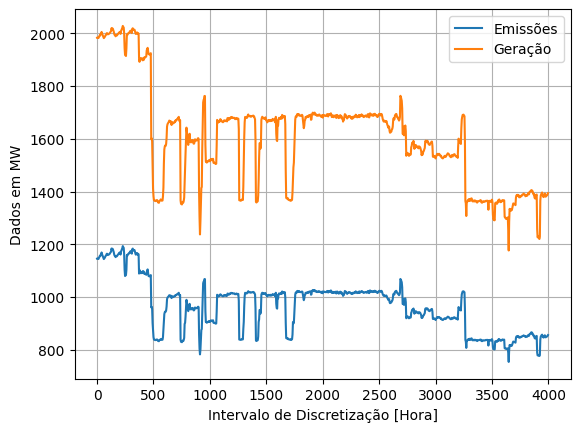

In [8]:
x_fig = np.linspace(0,len(y_pred),len(x_test))
tempo_inicio = 0
tempo_fim = 1000

ger = tab_trat[['Dia-Hora','Geração']].loc[tab_trat['Usina'].isin(usina)]
ger = ger.groupby('Dia-Hora').sum()

plt.figure()
plt.plot(x_fig[tempo_inicio:tempo_fim],y_pred[tempo_inicio:tempo_fim], x_fig[tempo_inicio:tempo_fim],ger[tempo_inicio:tempo_fim])
plt.legend(['Emissões','Geração'])
plt.xlabel('Intervalo de Discretização [Hora]')
plt.ylabel('Dados em MW')
#plt.title(f'Regressão {usina} (MSE: {mse.result().numpy():.4f})')
plt.grid()
print(f'Regressão {usina} (MSE: {mse.result().numpy():.4f})') if usina != '' else print('Regressão de todas as usinas')
plt.show()

#### Gráfico com dois eixos Y

Gráfico referente à usina ['Candiota III', 'J. Lacerda C', 'Norte Fluminense', 'Santa Cruz']



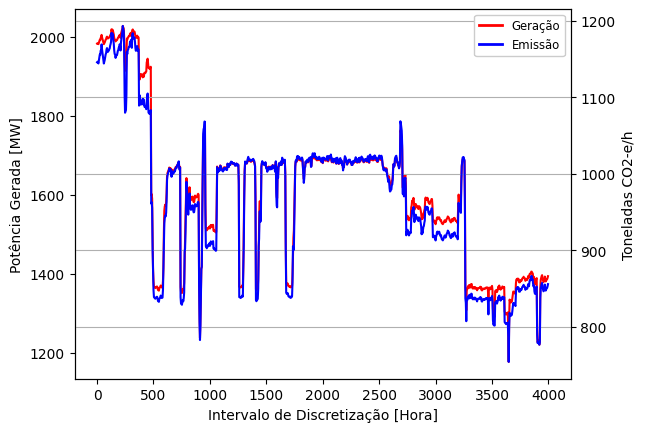

In [9]:
# Gráfico com dois eixos Y

x_fig = np.linspace(0,len(y_pred),len(x_test))
tempo_inicio = 0
tempo_fim = 1000

ger = tab_trat[['Dia-Hora','Geração']].loc[tab_trat['Usina'].isin(usina)]
ger = ger.groupby('Dia-Hora').sum()

fig,ax1 = plt.subplots()

ax1.set_xlabel('Intervalo de Discretização [Hora]')
ax1.set_ylabel('Potência Gerada [MW]')
ax1.plot(x_fig[tempo_inicio:tempo_fim],ger[tempo_inicio:tempo_fim],color='r')

ax2 = ax1.twinx()
ax2.set_ylabel('Toneladas CO2-e/h')
ax2.plot(x_fig[tempo_inicio:tempo_fim],y_pred[tempo_inicio:tempo_fim],color='b')
ax2.grid(True)

# Adicionando legendas personalizadas
legend_elements = [
    Line2D([0], [0], color='r', lw=2, label='Geração'),
    Line2D([0], [0], color='b', lw=2, label='Emissão'),
    #Line2D([0], [0], color='w', lw=0, label=f'Potência Instalada: {iema_temp['Potência Instalada (MW)'].loc[iema_temp['Usina'] == usina].values[0]:.0f}MW'),
    #Line2D([0], [0], color='w', lw=0, label=f'Ciclo de Operação: {iema_temp['Ciclo de Operação'].loc[iema_temp['Usina'] == usina].values[0]}'),
    #Line2D([0], [0], color='w', lw=0, label=f'Combustível: {iema_temp['Combustível'].loc[iema_temp['Usina'] == usina].values[0]}')]
]
# Unindo as legendas
ax2.legend(handles=legend_elements, loc='best', fontsize='small', facecolor='white', framealpha=1)

print(f'Gráfico referente à usina {usina}\n') if usina != '' else print('Gráfico referente à todas as usinas')
plt.show()

### Gráfico 3D

In [ ]:
# Treino da Rede para Obter o Erro

neur_max = 20
z = np.array([])

dir = 'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Código'

if os.path.isfile(f'{dir}\\MSE {usina} - Gráfico 3D.txt'):
  print(f'Valores de erro para usina {usina} já existentes.')
else:
  for i in range(1, neur_max+1):
    print(f'Treinando para {i} neurônio(os) na primeira camada')

    for j in range(1, neur_max+1):
      K.clear_session()

      rede = tf.keras.Sequential()
      rede.add(tf.keras.layers.Dense(i,activation='relu'))
      rede.add(tf.keras.layers.Dense(j,activation='relu'))
      rede.add(tf.keras.layers.Dense(1))

      opt = tf.keras.optimizers.Adam(learning_rate=0.001)
      rede.compile(optimizer=opt, loss='mean_squared_error')

      # Inicializa a medição do erro quadrático médio
      mse = tf.keras.metrics.MeanSquaredError()

      #Treinamento e teste da rede
      print(f'Treinando para {j} neurônio(os) na segunda camada')
      rede.fit(x_train,y_train,epochs=2000,verbose=0)
      y_pred = rede.predict(x_train)

      mse.update_state(y_train, y_pred)
      z = np.append(z,mse.result().numpy())
      print(f'Treinamento concluído. Erro: {mse.result().numpy():.2f}\n')

  np.savetxt(f'MSE {usina} - Gráfico 3D.txt', z)
  print(f'Todos os valores de erro para usina {usina} salvos.')

In [11]:
# Gráfico 3D relacionando erro pela quantia de neurônios

x = np.array([])
for i in range(neur_max):
  for j in range(neur_max):
    x = np.append(x,i+1)

y = np.array([])
for i in range(neur_max):
  for j in range(neur_max):
    y = np.append(y,j+1)

dir = f'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\Python\\Código'

if os.path.isfile(f'{dir}\\MSE {usina} - Gráfico 3D.txt'):

  z = np.loadtxt(f'MSE {usina} - Gráfico 3D.txt')

  cm = 1/2.54
  fig = plt.figure(figsize=(20*cm,20*cm))
  ax = fig.add_subplot(111, projection='3d')

  # Plotando pontos
  ax.scatter(x, y, z, c='r', marker='o')

  # Plotando linhas (Opcional)
  # for i in range(len(x)):
  #     ax.plot([x[i], x[i]], [y[i], y[i]], [0, z[i]], color='b')

  # Plotando faces
  ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True, color='cyan',edgecolors='k')

  # Mudando o passo dos eixos
  ax.set_xticks(np.arange(0, 21, 2))  # Define os ticks do eixo x
  ax.set_yticks(np.arange(0, 21, 2))  # Define os ticks do eixo y
  #ax.set_zticks(np.arange(0, 1))  # Define os ticks do eixo z

  # Configurações adicionais
  ax.set_xlabel('Neurônios na 1ª Camada Oculta', fontsize=12)
  ax.set_ylabel('Neurônios na 2ª Camada Oculta', fontsize=12)
  ax.set_zlabel('Erro', fontsize=12,rotation=90)

  plt.show()

else:
  print(f'Erros para usina {usina} não gerados')

## Algoritmos Auxiliares (Definir as variáveis antes)

### Algoritmo para Preenchimento das Tabelas IEMA Utilizando uma Tabela Base (ARRUMAR)

In [ ]:
dir = 'G:\\Meu Drive\\Documentos UFSCar\\Iniciação Científica (Giovanni Grizante)\\IEMA'
tab_temp1 = {}
tab_temp2 = []

ano_base = input('Escolha o ano base: ')
tipo_base = input('Escolha a tabela base (Geração ou Emissão): ').upper()
ano_preencher = input('Escolha o ano a ser preenchido: ')
tipo_preencher = input('Escolha a tabela a ser preenchida (Geração ou Emissão): ').upper()

if (ano_base in iema.keys()) and (ano_preencher in iema.keys()) and (tipo_base == 'GERAÇÃO' or tipo_base == 'EMISSÃO') and (tipo_preencher == 'GERAÇÃO' or tipo_preencher == 'EMISSÃO'):

  if tipo_base == tipo_preencher and ano_base == ano_preencher:
    print('\nAVISO: Redundância nas informações. Verificar preenchimento solicitado.')

  else:
    tipo_base_num = 0 if tipo_base == 'GERAÇÃO' else 1
    tipo_preencher_num = 0 if tipo_preencher == 'GERAÇÃO' else 1

    tab_temp2 = pd.merge(iema[ano_base][tipo_base_num], iema[ano_preencher][tipo_preencher_num], how='right', on='Usina', suffixes=(f'_{ano_base}_{tipo_base}', f'_{ano_preencher}_{tipo_preencher}'))

    tab_temp2[f'Município_{ano_preencher}_{tipo_preencher}'] = tab_temp2[f'Município_{ano_base}_{tipo_base}']
    tab_temp2[f'Estado_{ano_preencher}_{tipo_preencher}'] = tab_temp2[f'Estado_{ano_base}_{tipo_base}']
    tab_temp2[f'Combustível_{ano_preencher}_{tipo_preencher}'] = tab_temp2[f'Combustível_{ano_base}_{tipo_base}']
    tab_temp2[f'Ciclo de Operação_{ano_preencher}_{tipo_preencher}'] = tab_temp2[f'Ciclo de Operação_{ano_base}_{tipo_base}']

    tab_temp1[ano_preencher] = tab_temp2.iloc[:, [0,7,8,10,11]]   # ARRUMAR PARA FAZER COM QUE SEJAM ESCOLHIDAS AS COLUNAS PELO NOME DELAS

    if os.path.isfile(f'{dir}/{ano_preencher}/IEMA {ano_preencher} {tipo_preencher}_Código.xlsx') == False:
      tab_temp1[ano_preencher].to_excel(f'{dir}/{ano_preencher}/IEMA {ano_preencher} {tipo_preencher}_Código.xlsx',index=False)
      print('\nAVISO: Geração de arquivo concluída. Verificar pasta daqui alguns segundos.')

    else:
      print('\nAVISO: Arquivo ja existente. Verificar pasta.')

else:
  print('\nAVISO: Informação não disponível ou erro de digitação.')